In [11]:
from keras.callbacks import EarlyStopping ,ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [12]:
# reading the data from storage
# replace the path with yours 
dataset_path = "/content/drive/MyDrive/IMDB Dataset.csv"
dataframe = pd.read_csv(dataset_path)

In [13]:
dataframe.shape

(50000, 2)

In [14]:
dataframe['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [15]:
# mapping categorical labels to numbers 0,1
dataframe['sentiment'] = dataframe['sentiment'].map({'positive':0,'negative':1})

# splitting the data 80% for training and 20% testing
train_df = dataframe.sample(frac=0.8,random_state=100)
test_df = dataframe.drop(train_df.index)

In [16]:
train_df.shape

(40000, 2)

In [17]:
test_df.shape

(10000, 2)

In [18]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset cleaning


In [19]:
import string, re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

# custom review cleaning method, we remove stopdwords <br> HTML tags
# have tried stemming but there was no improvements in model's performance

def custom_standardization(input_data):
  stripped_html = input_data.replace('<br />', '')
  # text = " ".join([stemmer.stem(word) for word in stripped_html.split() if re.search("\w", word) and word not in stop_words ])
  text2 = " ".join([word for word in stripped_html.split() if re.search("\w", word) and word not in stop_words ])
  return text2

In [20]:
print(train_df['review'].values[0])

This is a documentary about homeless women. It was interesting in the sense that this focused on women who are engaged socially - having jobs and lasting friendships - but are in situations where they can not afford housing.<br /><br />I found some of the women covered to be interesting, but there was little focus or progression in the story. The direction and editing failed to maintain my attention. There were differences in the stories of these women, of course, but the message was essentially the same and could have been told by focusing on any one of them in more depth.<br /><br />I made it to the end of the movie, but it was a rather boring journey.


In [21]:
# we iterate through every review and run our custom method of text cleaning from above
i=0
for review_text in train_df['review'].values:
    train_df['review'].values[i] = custom_standardization(review_text)
    i+=1

In [22]:
# review text after first step cleaning
print(train_df['review'].values[0])

This documentary homeless women. It interesting sense focused women engaged socially jobs lasting friendships situations afford housing.I found women covered interesting, little focus progression story. The direction editing failed maintain attention. There differences stories women, course, message essentially could told focusing one depth.I made end movie, rather boring journey.


In [23]:
tokenizer  = tf.keras.preprocessing.text.Tokenizer(num_words=10000,
                                                  oov_token = '<UNK>',
                                                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                  lower=True,
                                                  split=' ',)
tokenizer.fit_on_texts(np.append(train_df['review'].values,test_df['review'].values))

# unique words present in our dataset
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


In [24]:
pad_type = 'post'
trunc_type = 'post'
#  convert text word to number by assigning the unique number to each word. 
train_seq = tokenizer.texts_to_sequences(train_df["review"])

# Get maximum length of all training sequences 
max_length = max([len(x) for x in train_seq])

train_data = tf.keras.preprocessing.sequence.pad_sequences(train_seq,
                                                           padding=pad_type,
                                                           truncating=trunc_type,
                                                           maxlen=max_length)


test_seq = tokenizer.texts_to_sequences(test_df["review"])

# pad the sequences to max_length.
# we will be adding 0's towards the end if sequence length < max_length
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_seq,
                                                          padding=pad_type,
                                                          truncating=trunc_type,
                                                          maxlen=max_length)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq,
                                                            padding=pad_type,
                                                            truncating=trunc_type,
                                                            maxlen=max_length)

print("Testing sequences:\n", test_seq[:2])
print("\nPadded testing sequences:\n", test_padded[:2])
print("\nPadded testing shape:",test_padded.shape)

Testing sequences:
 [[45, 31, 16, 171, 5319, 5798, 2143, 31, 262, 16, 10, 4, 45, 31, 63, 143, 91, 110, 159, 31, 262, 65, 10, 4, 577, 22, 109, 1593, 399, 8, 15, 15, 39, 1209], [10, 6, 741, 11, 67, 170, 59, 130, 36, 68, 552, 1, 969, 2061, 342, 2680, 4484, 718, 158, 196, 1177, 1, 2, 991, 236, 33, 5, 33, 8, 1196, 3292, 68, 36, 9, 131, 18, 43, 30, 150, 593, 11, 367, 97, 88, 1600, 8, 232, 1262, 2, 78, 15, 15, 225, 3, 1095, 2, 1156, 488, 266, 1, 8, 1, 97, 11, 25, 451, 7, 4038, 755, 226, 93, 8, 262, 67, 582, 87, 263, 7149, 11, 4437, 2, 549, 9, 2, 2067, 9, 7, 575, 6788, 211, 290, 302, 2, 305, 464, 437, 5, 326, 9, 10, 843, 6, 15, 15, 43, 14, 7, 6788, 11, 67, 46, 115, 2, 1, 9, 266, 18, 1, 208, 68, 8, 13, 10, 48, 1, 2, 259, 8173, 9, 76, 14, 1447, 1750, 97, 7, 185, 9, 248, 8481, 156, 4032, 1, 7, 1940, 1130, 27, 4915]]

Padded testing sequences:
 [[ 45  31  16 ...   0   0   0]
 [ 10   6 741 ...   0   0   0]]

Padded testing shape: (10000, 1528)


In [25]:
print(train_data.shape)
print(test_data.shape)


(40000, 1528)
(10000, 1528)


In [26]:
len(word_index)

125226

In [27]:
train_label = train_df['sentiment'].values
test_label = test_df['sentiment'].values

In [28]:
vocab_size = len(word_index) + 1

In [29]:
# adding the model's layers and outputting a summary of the architecture
def create_model():
    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, 32,
                                input_length=max_length),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(1,activation="sigmoid")])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1528, 32)          4007264   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,007,297
Trainable params: 4,007,297
Non-trainable params: 0
_________________________________________________________________


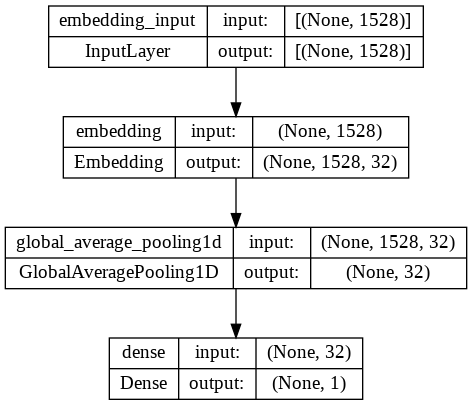

In [30]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

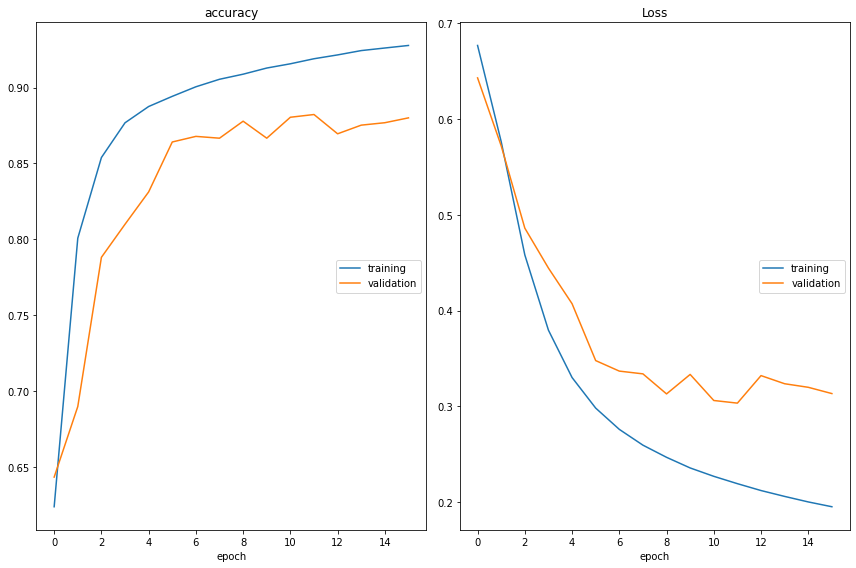

accuracy
	training         	 (min:    0.624, max:    0.928, cur:    0.928)
	validation       	 (min:    0.643, max:    0.882, cur:    0.880)
Loss
	training         	 (min:    0.195, max:    0.677, cur:    0.195)
	validation       	 (min:    0.303, max:    0.643, cur:    0.313)

Epoch 16: val_accuracy did not improve from 0.88220
Restoring model weights from the end of the best epoch: 12.
1250/1250 [==============================] - 7s 5ms/step - loss: 0.1953 - accuracy: 0.9277 - val_loss: 0.3134 - val_accuracy: 0.8800
Epoch 16: early stopping


In [31]:
# installing a library for live plotting the results obtained from training the model
# we also do configure ModelCheckpoint and EarlyStopping callbacks to save the best model
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback
checkpoint = ModelCheckpoint("/content/best_NLP_IMDB.h5", monitor="val_accuracy",
                             save_best_only=True, mode='max', verbose=1)

es = EarlyStopping(monitor="val_accuracy",
                  patience=4,
                  verbose=1,
                  restore_best_weights=True)


call_back = [PlotLossesCallback(),checkpoint,es]
epochs = 25

history = model.fit(train_data,
                    train_label,
                    epochs=epochs,
                    validation_data = (test_data,test_label),
                    callbacks=call_back)

In [32]:
loss, accuracy = model.evaluate(test_data,test_label)

print(f"Accuracy % : {accuracy*100}")
print(f"Loss     : {loss}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3034 - accuracy: 0.8822
Accuracy % : 88.22000026702881
Loss     : 0.3034493625164032


In [33]:
# metrics available in history
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

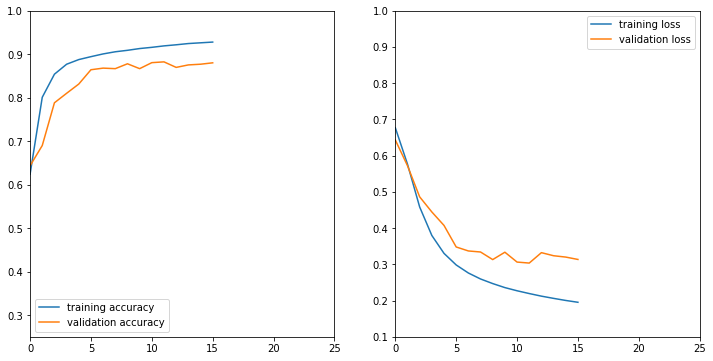

In [34]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label="training accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.legend()
plt.ylim(0.25, 1.0)
plt.xlim(0, epochs)
plt.subplot(1, 2, 2)
plt.plot(loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.ylim(0.1, 1)
plt.xlim(0, epochs)

plt.legend()

plt.show()

In [35]:
# we round the predictions so that we get an array with values of 0 or 1
# this is so that we can use the variable when displaying the confusion matrix and classification report
preds = model.predict(test_data,verbose=2).round()

# full score predictions (floating number format between 0 and 1)
preds_full = model.predict(test_data,verbose=2)

313/313 - 0s - 470ms/epoch - 2ms/step
313/313 - 0s - 382ms/epoch - 1ms/step


In [36]:
# showing the first 5 values of the full predictions
# the closer it is to 0 means the review is positive,
#  otherwise means it is likely to be negative
print(preds_full[:5])

# we do set a threshold of 0.5 , value which separates positive and negative reviews
# and display the first 3 reviews from the test dataset

for i in range(3):
  print()
  if(preds_full[i] < 0.5):
    print(preds_full[i], "------- positive")
  else:
      print(preds_full[i], "------- negative")
  print("----------")
  print(test_df['review'].values[i])


[[0.1738607 ]
 [0.65808827]
 [0.68268865]
 [0.9305932 ]
 [0.08932304]]

[0.1738607] ------- positive
----------
If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!

[0.65808827] ------- negative
----------
This film tried to be too many things all at once: stinging political satire, Hollywood blockbuster, sappy romantic comedy, family values promo... the list goes on and on. It failed miserably at all of them, but there was enough interest to keep me from turning it off until the end.<br /><br />Although I appreciate the spirit behind WAR, INC., it depresses me to see such a clumsy effort, especially when it will be taken by its targets to reflect the lack of the existence of a serious critique, rather than simply the poor writing, direction, and production of this particular film.<br /><br />There is a critique to be made about the corporatization of war. But po

True Positive(TP)  =  4533
False Positive(FP) =  747
True Negative(TN)  =  4289
False Negative(FN) =  431


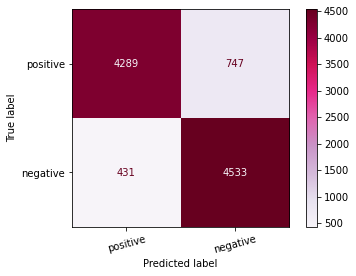

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# calculating the values and plotting the confusion matrix
cm = confusion_matrix(test_label, preds)

TN, FP, FN, TP = confusion_matrix(test_label, preds).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

labels =['positive', 'negative']


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=labels)
 
disp.plot(cmap='PuRd', xticks_rotation=15)


In [38]:
from sklearn.metrics import classification_report

print(classification_report(test_label,preds,target_names=labels))

              precision    recall  f1-score   support

    positive       0.91      0.85      0.88      5036
    negative       0.86      0.91      0.89      4964

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def plot_roc_curve():
   # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(test_label, preds_full)

    # Plot the ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

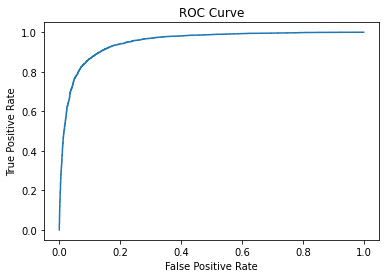

model AUC score: 0.9497853568729003


In [40]:
plot_roc_curve()
print(f'model AUC score: {roc_auc_score(test_label, preds_full)}')